In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

Calculating Lipinski descriptors:

- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

Based on Absorption, Distribution, Metabolism, and Excretion (ADME), AKA pharmacokinetic profile.

In [5]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [6]:
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
    
    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_molLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_molLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])
        
        if (i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)

    return descriptors

In [8]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
240,328.466,3.34562,1.0,5.0
241,222.379,-1.99300,1.0,3.0
242,485.559,0.54470,5.0,7.0
243,222.379,-1.99300,1.0,3.0


In [10]:
df_combined = pd.concat([df, df_lipinski], axis = 1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,380.19,active,328.466,3.34562,1.0,5.0
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.00,active,222.379,-1.99300,1.0,3.0
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,161.00,active,485.559,0.54470,5.0,7.0
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.96,active,222.379,-1.99300,1.0,3.0


For the IC50 data to be more uniformly distributed, the IC50 will be converted to the negative logarthmic scale (-log10(IC50)).

What does the original IC50 distribution look like?

- Take IC50 vlaues from the standard_value column and convert it from nM to M (*10^-9)
- Take the molar value and apply -log10
- Delete the standard_value column and create new pIC50 column

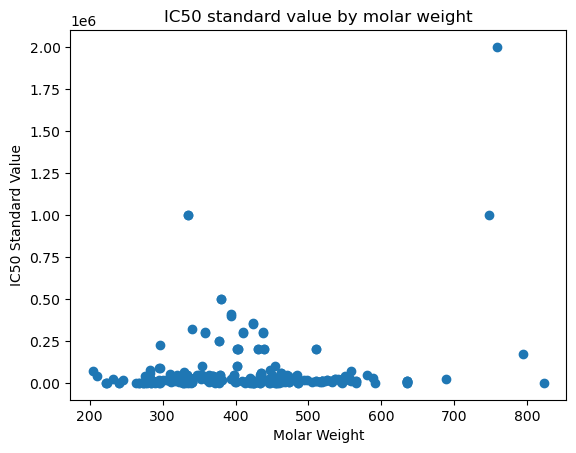

In [15]:
# add scatter plots to compare distributions
import matplotlib.pyplot as plt

plt.scatter(x=df_combined['MW'], y=df_combined['standard_value'])
plt.title("IC50 standard value by molar weight")
plt.xlabel("Molar Weight")
plt.ylabel("IC50 Standard Value")
plt.show()

In [17]:
df_combined.standard_value.describe()

count    2.450000e+02
mean     6.893878e+04
std      1.851962e+05
min      5.000000e+01
25%      5.000000e+03
50%      1.500000e+04
75%      4.700000e+04
max      2.000000e+06
Name: standard_value, dtype: float64

In [28]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value']:
        molar = i * (10**-9) # convert nM to M
        pIC50.append(-np.log10(molar))
    
    input['pIC50'] = pIC50
    x = input.drop('standard_value', axis=1)
    return x

In [29]:
df_final = pIC50(df_combined)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,6.419999
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.782516
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,6.793174
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.779997


In [30]:
df_final.pIC50.describe()

count    245.000000
mean       4.894585
std        0.911338
min        2.698970
25%        4.327902
50%        4.823909
75%        5.301030
max        7.301030
Name: pIC50, dtype: float64

In [32]:
df_2class = df_final[df_final.bioactivity != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,6.419999
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.782516
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,6.793174
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.779997


In [33]:
import seaborn as sns
sns.set(style='ticks')